In [40]:
import pickle

with open("sample_model/model.pkl", "rb") as f:
    model = pickle.load(f)

with open("sample_model/feature_names.pkl", "rb") as f:
    feature_names = pickle.load(f)

with open("sample_model/sample_instance.pkl", "rb") as f:
    instance_to_explain = pickle.load(f)

# **LIME Implementation| Explainable artificial intelligence**

In [42]:
import numpy as np

def kernel_function(distances, kernel_width=0.75):
    """Exponential kernel function for weighting."""
    return np.sqrt(np.exp(-(distances ** 2) / (kernel_width ** 2)))

In [43]:
def generate_perturbations(instance, num_samples=1000):
    """Generate random perturbations of the input instance."""
    perturbations = np.random.randn(num_samples, len(instance))
    perturbations = perturbations * np.std(instance) + instance
    return perturbations

In [44]:
def get_weights(instance, perturbations):
    """Calculate distances and apply the kernel function to get weights."""
    distances = np.linalg.norm(perturbations - instance, axis=1)
    weights = kernel_function(distances)
    return weights

In [45]:
from sklearn.linear_model import Ridge

def explain_instance(model, instance, num_samples=1000):
    """Generate explanations for a single instance."""
    # Generate perturbations
    perturbations = generate_perturbations(instance, num_samples)
    
    # Get model predictions for the perturbations
    predictions = model.predict_proba(perturbations)[:, 1]
    
    # Calculate weights using the kernel function
    weights = get_weights(instance, perturbations)
    
    # Fit a Ridge Regression model on the weighted samples
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(perturbations, predictions, sample_weight=weights)
    
    # Return the coefficients as feature importance
    return ridge_model.coef_

In [46]:
feature_importance = explain_instance(model, instance_to_explain)

In [47]:
import pandas as pd

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", key=abs, ascending=False)

In [48]:
importance_df

,Feature,Importance
21,worst texture,-0.137898
28,worst symmetry,-0.123221
10,radius error,-0.121870
7,mean concave points,-0.099115
13,area error,-0.089574
26,worst concavity,-0.089257
6,mean concavity,-0.085995
20,worst radius,-0.083550
23,worst area,-0.080440
27,worst concave points,-0.076185


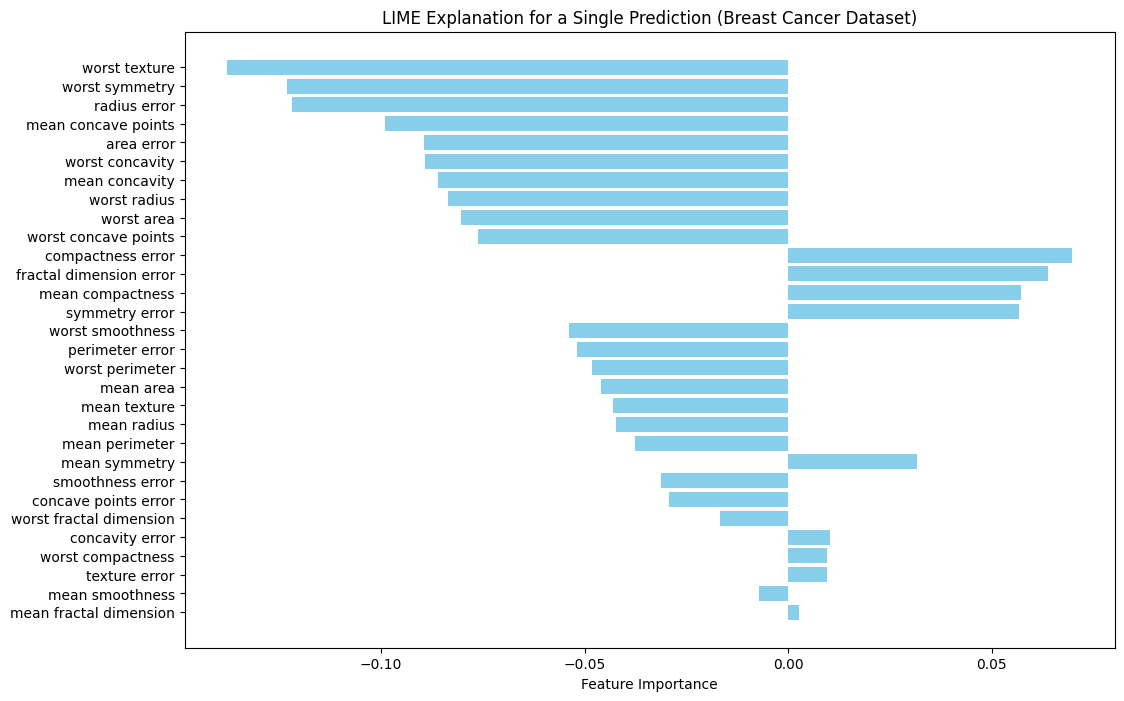

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.title("LIME Explanation for a Single Prediction (Breast Cancer Dataset)")
plt.gca().invert_yaxis()
plt.show()